# Coded Diffraction Pattern (CDP) with gPIE

This notebook demonstrates phase retrieval from coded diffraction patterns using EP-based inference with the gPIE framework.

We reconstruct a complex-valued image from multiple amplitude-only Fourier measurements modulated by random phase masks.

### 1. Imports and Setup

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from gpie import model, GaussianPrior, fft2, AmplitudeMeasurement, pmse
from gpie.core.linalg_utils import random_phase_mask

# load sample image from sk-image library
import os
import sys
EXAMPLES_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, EXAMPLES_DIR)

from io_utils import load_sample_image

### 2. Problem Definition

In coded diffraction pattern (CDP) imaging, the object wave $ \mathbf{x} $ is unknown,  
and we observe multiple measurements of the form:

$$
\mathbf{y}_i = \left| \mathcal{F}(\mathbf{m}_i \odot \mathbf{x}) \right| + \varepsilon_i, \quad i = 1, \dots, N
$$

Where:

- $ \mathbf{m}_i $: Random phase mask
- $ \mathcal{F} $: 2D Fourier transform
- $ \varepsilon_i \sim \mathcal{N}(0, \sigma^2) $: Gaussian noise

Our goal is to recover $ \mathbf{x} $ from $\{ \mathbf{y}_i \}_{i=1}^N$.  
Bayesian inference is performed via:

$$
p(\mathbf{x} \mid \{ \mathbf{y}_i \}) \propto \left( \prod_{i=1}^N p(\mathbf{y}_i \mid \mathbf{x}) \right) \cdot \mathcal{N}(\mathbf{x}; 0, I)
$$

We use a Gaussian prior and perform inference using Expectation Propagation (EP), in the case $N = 3$.

### 3. Define Factor Graph Class

In [7]:
@model
def coded_diffraction_pattern(shape, n_measurements, phase_masks, noise):
    x = ~GaussianPrior(event_shape=shape, label="sample", dtype = np.complex64)
    for i in range(n_measurements):
        y = phase_masks[i] * x
        z = fft2(y)
        AmplitudeMeasurement(var=noise) << z

Instead of explicitly looping over all measurements, one can also replicate a Wave node using `replicate()`. For e.g.,  


```
from gpie import replicate

@model
def coded_diffraction_pattern(shape, phase_masks, noise):
    x = ~GaussianPrior(event_shape=shape, label="sample", dtype=np.complex64)
    x_repl = replicate(x, batch_size=len(phase_masks))  # replicate the sample across batches
    y = phase_masks * x_repl
    z = fft2(y)
    AmplitudeMeasurement(var=noise, damping=0.3) << z
```

### 4. Prepare Data and Build Graph

In [8]:
# Settings
H = W = 256
noise_var = 1e-4
n_measurements = 4
rng = np.random.default_rng(seed=42)

# Phase masks
phase_masks = [random_phase_mask((H, W), rng=rng, dtype=np.complex64) for _ in range(n_measurements)]

# Load amplitude and phase images
amp = load_sample_image("camera", shape=(H, W))
phase = load_sample_image("moon", shape=(H, W))
true_complex = amp * np.exp(1j * 2 * np.pi * phase) 

# Construct graph and inject sample
g = coded_diffraction_pattern(noise=noise_var,
                              n_measurements=n_measurements,
                              phase_masks=phase_masks,
                              shape=(H, W))

g.set_init_rng(np.random.default_rng(seed=1))
g.get_wave("sample").set_sample(true_complex.astype(np.complex64))

# Generate measurements
g.generate_sample(rng=np.random.default_rng(seed=999), update_observed=True)

- A single complex-valued latent variable $ \mathbf{x} $ is defined via a Gaussian prior
- For each measurement $ i $, a random phase mask $ \mathbf{m}_i $ is applied
- The masked image is transformed via FFT and observed through amplitude-only measurement

- `get_wave("sample")` retrieves the latent node labeled `"sample"`  
- `set_sample(...)` injects the true complex image  
- `generate_sample(...)` simulates noisy observed data


### 6. Run Inference

In [9]:
n_iter = 400
pse_list = []

true_x = g.get_wave("sample").get_sample()

def monitor(graph, t):
    if t % 40 == 0 or t == n_iter - 1:
        est = graph.get_wave("sample").compute_belief().data
        err = pmse(est, true_x)
        pse_list.append(err)
        print(f"[t={t}] PMSE = {err:.5e}")

g.run(n_iter=n_iter, callback=monitor)

[t=0] PMSE = 2.93498e+00
[t=40] PMSE = 4.81156e-01
[t=80] PMSE = 7.16830e-02
[t=120] PMSE = 1.64680e-04
[t=160] PMSE = 1.49134e-04
[t=200] PMSE = 1.49135e-04
[t=240] PMSE = 1.49135e-04
[t=280] PMSE = 1.49135e-04
[t=320] PMSE = 1.49135e-04
[t=360] PMSE = 1.49135e-04
[t=399] PMSE = 1.49135e-04


### 7. Visualize Results

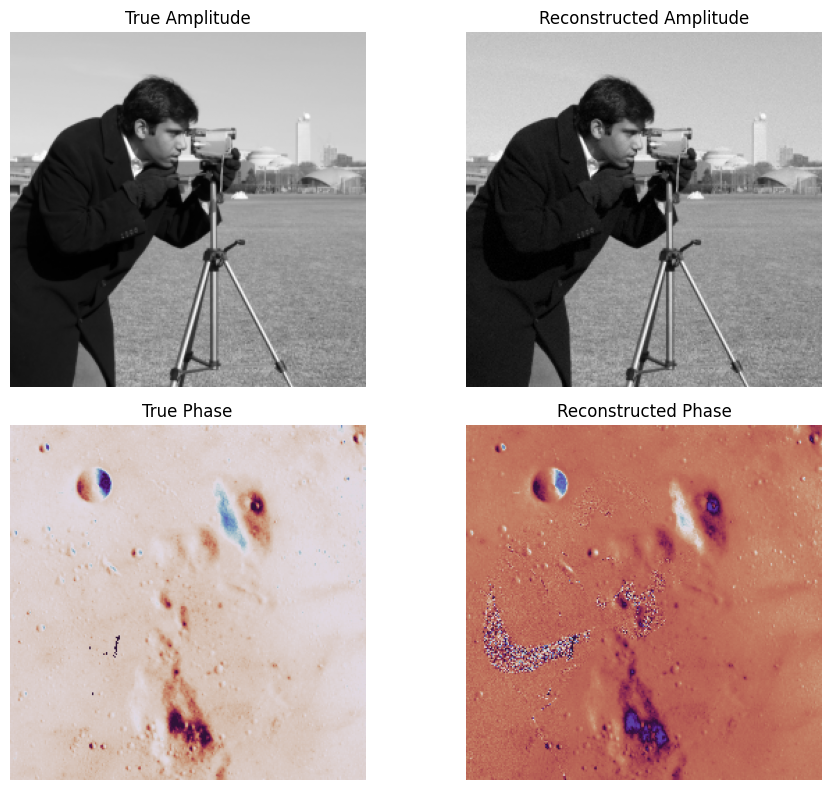

In [10]:
est = g.get_wave("sample").compute_belief().data[0] 
true_x = true_x[0]

true_amp = np.abs(true_x)
true_phase = np.angle(true_x) * (true_amp > 1e-5)

est_amp = np.abs(est)
est_phase = np.angle(est) * (true_amp > 1e-5)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes[0,0].imshow(true_amp, cmap='gray')
axes[0,0].set_title("True Amplitude")

axes[0,1].imshow(est_amp, cmap='gray')
axes[0,1].set_title("Reconstructed Amplitude")

axes[1,0].imshow(true_phase, cmap='twilight')
axes[1,0].set_title("True Phase")

axes[1,1].imshow(est_phase, cmap='twilight')
axes[1,1].set_title("Reconstructed Phase")

for ax in axes.flat:
    ax.axis("off")

plt.tight_layout()
plt.show()
